In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter
import os
import torch
import random

def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU 
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

%matplotlib inline
wd = Path.cwd()
data_path = wd.parent / 'data'

## Cathode

In [2]:
Cathode_Normal = sorted([x for x in Path(os.path.join(data_path, "230507/Cathode/Normal")).glob("*.csv")])
Cathode_Normal = sorted(Cathode_Normal)

Cathode_Abnormal = sorted([x for x in Path(os.path.join(data_path, "230507/Cathode/Abnormal")).glob("*.csv")])
Cathode_Abnormal = sorted(Cathode_Abnormal)
len(Cathode_Normal), len(Cathode_Abnormal)

(31, 17)

In [3]:
# data = pd.read_csv(os.path.join(data_path, "230507/Cathode/Normal/20230412_110032_0__03_Total.csv"))
# len(data)

# data2 = pd.read_csv(os.path.join(data_path, "230507/Cathode/Normal/31.csv"))
# len(data2)

In [4]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

### Dataset별 bead detection 후 time series concat

In [5]:
def slice_bead_data(path, set_bead_100=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    if not set_bead_100:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    else:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

    if not set_bead_100:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])

    else:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])
                
    return total_data

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

## Train Test split
### Train -> 35개 정상 dataset 중 80%인 28개
### Test -> 18개 비정상 dataset + 정상 7개 dataset = 25개 dataset

In [6]:
import warnings
warnings.filterwarnings("ignore")
data_folder_list = Cathode_Normal + Cathode_Abnormal
num_train_dataset = 28
Cathode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Cathode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Cathode_Train = pd.concat([Cathode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Cathode_Test = pd.concat([Cathode_Test, bead_i])


warning index: 59479
error index: 59578
warning index: 60128
error index: 60227
warning index: 60777
error index: 60876
warning index: 61427
error index: 61526
warning index: 62076
error index: 62175
warning index: 62725
error index: 62824
warning index: 63374
error index: 63473
warning index: 64022
error index: 64121
warning index: 64671
error index: 64770
warning index: 65321
error index: 65420
warning index: 65970
error index: 66069
warning index: 66619
error index: 66718
warning index: 67268
error index: 67367
warning index: 67917
error index: 68016
warning index: 68567
error index: 68666
warning index: 69216
error index: 69315
warning index: 69865
error index: 69964
warning index: 70514
error index: 70613
warning index: 71163
error index: 71262
warning index: 71813
error index: 71912
warning index: 72462
error index: 72561
warning index: 73111
error index: 73210
warning index: 73760
error index: 73859
warning index: 74409
error index: 74508
warning index: 75058
error index: 75157


In [7]:
# Cathode_Test2 = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
# for i in range(num_train_dataset, len(data_folder_list)):
#     bead_i = slice_bead_data(str(data_folder_list[i]))
#     Cathode_Test2 = pd.concat([Cathode_Test2, bead_i])

# Cathode_Test2.groupby(['identifier']).count()['bead_num'].sort_values()[0:54]
# # plot x: 지워, y: LO

# Cathode_Test[(Cathode_Test['label']==1) & (Cathode_Test['dataset_idx']=='06')].groupby(['identifier']).plot(y='LO',figsize=(3,1), legend=False, title='bead_num')

In [8]:
Cathode_Test.groupby(['identifier']).count()['bead_num'].unique()

array([100])

### LSTM-VAE

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import argparse

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sys
sys.path.append("..")
from tsad.data import BuildDataset
from tsad.models import LSTM_VAE

from omegaconf import OmegaConf

In [10]:
window_size = 100
slide_size = 100
model_type = 'reconstruction'
valid_split_rate = 0.8

loader_params={
  'batch_size': 32,
  'shuffle': False,
  'num_workers': 8,
  'pin_memory': True
}

In [11]:
#dataset.py의 load_dataset 함수
trn = Cathode_Train[['LO', 'BR', 'NIR', 'VIS']]
trn = trn.reset_index(drop=True)
trn = trn.dropna()
trn_ts = trn.index

# valid_split_index = int(len(trn) * valid_split_rate)
# dev = trn.iloc[valid_split_index:].to_numpy()
# trn = trn.iloc[:valid_split_index].to_numpy()
# dev_ts = trn_ts[valid_split_index:].to_numpy()
# trn_ts = trn_ts[:valid_split_index].to_numpy()

tst = Cathode_Test[['LO', 'BR', 'NIR', 'VIS']]
tst_ts = np.arange(len(tst))
tst_label = Cathode_Test[['label']]

In [12]:
trn.shape, tst.shape

((151200, 4), (108000, 4))

In [13]:
scaler = StandardScaler()
scaler.fit(trn)
trn = scaler.transform(trn)
# dev = scaler.transform(dev)
tst = scaler.transform(tst)

In [14]:
# Dataloader.py에 있는 데이터셋 구축 부분
# build dataset
trn_dataset = BuildDataset(trn, trn_ts, window_size, slide_size,
                            attacks=None, model_type=model_type)

# dev_dataset = BuildDataset(dev, dev_ts, window_size, slide_size,
#                             attacks=None, model_type=model_type)

tst_dataset = BuildDataset(tst, tst_ts, window_size, slide_size,
                            attacks=tst_label, model_type=model_type)

# of valid windows: 1512
# of valid windows: 1080


In [15]:
trn_dataloader = torch.utils.data.DataLoader(trn_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)


tst_dataloader = torch.utils.data.DataLoader(tst_dataset,
                                                batch_size=1,
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)

next(iter(trn_dataloader))['given'].shape[2]

4

In [16]:
# yaml file load
with open('../tsad/config.yaml') as f:
    config = OmegaConf.load(f)

params = config['LSTM_VAE']
params['feature_num'] = int(next(iter(trn_dataloader))['given'].shape[2])
params['gpu'] = 0
params['criterion'] = 'mse'

device = torch.device('cuda:{}'.format(params['gpu']) if torch.cuda.is_available() else 'cpu')

# set seed
torch_seed(77)

model = LSTM_VAE(params).to(device)

Use GPU: cuda:0


Epochs: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it] 


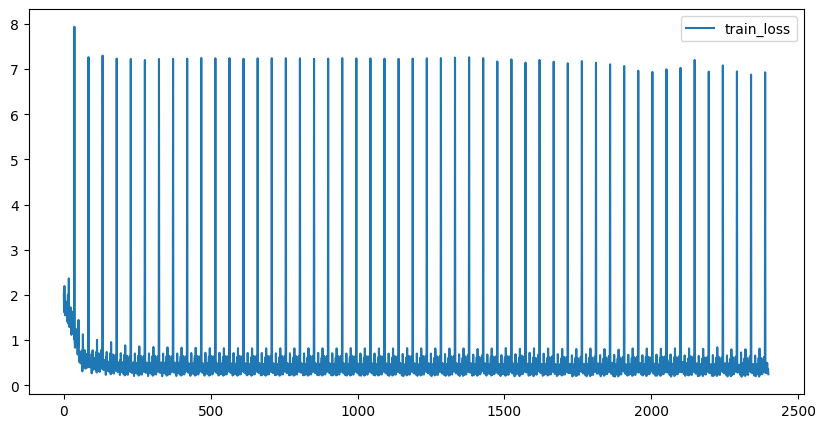

Epoch: 50, Steps: 48 cost time: 1.258422613143921 | Train Loss: 0.5204499 


[36]

In [17]:
torch_seed(77)
model.fit(train_loader = trn_dataloader, train_epochs=50)

In [18]:
scores, attack, _ = model.test(test_loader = tst_dataloader)

Batches: 100%|██████████| 1080/1080 [00:03<00:00, 278.35it/s]


In [19]:
windows_mean_scores = np.array([])
windows_max_scores = np.array([])
for i in range(0, len(scores), window_size):
    windows_mean_scores = np.append(windows_mean_scores, np.mean(scores[i:i+window_size]))
    windows_max_scores = np.append(windows_max_scores, np.max(scores[i:i+window_size]))

windows_labels=np.array([], dtype= float) # 0, 1: max in window
for i in range(0, len(tst_label), window_size):
    windows_labels = np.append(windows_labels, np.max(tst_label[i:i+window_size]))

windows_labels=windows_labels.astype(float)

## window mean

In [20]:
_, threshold_mean = bf_search(windows_mean_scores, windows_labels, start=min(windows_mean_scores), end=max(windows_mean_scores), step_num=100, K=100, verbose=True)
threshold_mean

search range:  0.023072389885783195 99.26007843017578
cur thr:  1.0154424502886832 [0.40657111755955333, 0.9873949164960119, 0.25599128261447407, 235.0, 159.0, 3.0, 683.0, 0.7578404475644853, 0.9478402071548547, 0.0] [0.40657111755955333, 0.9873949164960119, 0.25599128261447407, 235.0, 159.0, 3.0, 683.0, 0.7578404475644853, 0.9478402071548547, 0.0] 1.0154424502886832
cur thr:  2.007812510691583 [0.27391880440954197, 0.9864864198319986, 0.15904139260303493, 146.0, 160.0, 2.0, 772.0, 0.7578404475644853, 0.9478402071548547, 0.0] [0.40657111755955333, 0.9873949164960119, 0.25599128261447407, 235.0, 159.0, 3.0, 683.0, 0.7578404475644853, 0.9478402071548547, 0.0] 1.0154424502886832
cur thr:  3.0001825710944834 [0.201563725683867, 0.9903845201553346, 0.11220043450762054, 103.0, 161.0, 1.0, 815.0, 0.7578404475644853, 0.9478402071548547, 0.0] [0.40657111755955333, 0.9873949164960119, 0.25599128261447407, 235.0, 159.0, 3.0, 683.0, 0.7578404475644853, 0.9478402071548547, 0.0] 1.0154424502886832
c

1.0154424502886832

In [21]:
f1, precision, recall, _, _, _, _, auroc, _ =  calc_seq(windows_mean_scores, windows_labels, threshold_mean, 100, False)

print(f1, precision, recall)

0.40657111755955333 0.9873949164960119 0.25599128261447407


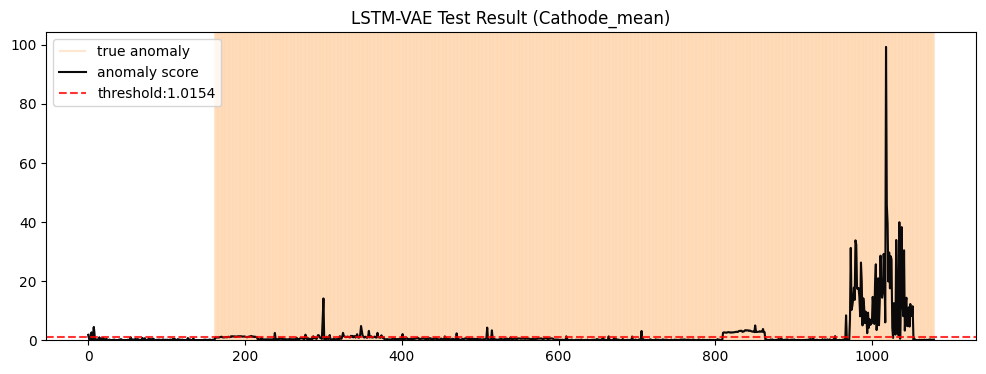

In [22]:
check_graph(windows_mean_scores, windows_labels, 1, threshold_mean)
plt.title('LSTM-VAE Test Result (Cathode_mean)')
plt.show()

## window max

In [23]:
_, threshold_max = bf_search(windows_max_scores, windows_labels, start=min(windows_max_scores), end=max(windows_max_scores), step_num=100, K=100, verbose=True)
threshold_max

search range:  0.16304826736450195 378.1044006347656
cur thr:  3.942461791038513 [0.35366625573615607, 0.9389670920672727, 0.21786492137402047, 200.0, 149.0, 13.0, 718.0, 0.7006912504370747, 0.9287298706283444, 0.0] [0.35366625573615607, 0.9389670920672727, 0.21786492137402047, 200.0, 149.0, 13.0, 718.0, 0.7006912504370747, 0.9287298706283444, 0.0] 3.942461791038513
cur thr:  7.721875314712524 [0.2925900371963442, 0.9753085817710752, 0.17211328788547617, 158.0, 158.0, 4.0, 760.0, 0.7006912504370747, 0.9287298706283444, 0.0] [0.35366625573615607, 0.9389670920672727, 0.21786492137402047, 200.0, 149.0, 13.0, 718.0, 0.7006912504370747, 0.9287298706283444, 0.0] 3.942461791038513
cur thr:  11.501288838386536 [0.27876276990903337, 0.9867549015394105, 0.16230936642364524, 149.0, 160.0, 2.0, 769.0, 0.7006912504370747, 0.9287298706283444, 0.0] [0.35366625573615607, 0.9389670920672727, 0.21786492137402047, 200.0, 149.0, 13.0, 718.0, 0.7006912504370747, 0.9287298706283444, 0.0] 3.942461791038513
c

3.942461791038513

In [24]:
f1, precision, recall, _, _, _, _, auroc, _ =  calc_seq(windows_max_scores, windows_labels, threshold_max, 100, False)

print(f1, precision, recall)

0.35366625573615607 0.9389670920672727 0.21786492137402047


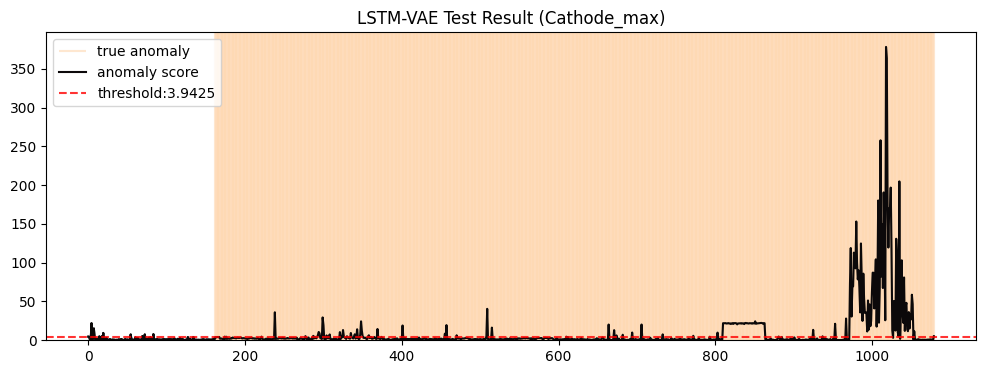

In [25]:
check_graph(windows_max_scores, windows_labels, 1, threshold_max)
plt.title('LSTM-VAE Test Result (Cathode_max)')
plt.show()
